# Quantum Time Series Analysis: Serial Model
Compatible with Qiskit 1.02+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.02 

### Aims
> *This script aims to create a single qubit serial variational model to fit some data and provide a forecast.*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
sys.path

['/home/jacob/miniconda3/envs/qiskit100/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/site-packages',
 '.',
 '..',
 '../..',
 '../../..']

In [1]:
import os
import numpy as np
import pylab
import math
import json
import time
import warnings

from IPython.display import clear_output

from utils.Target import *
# from utils.Window import *
# from utils.Callback import *
# from utils.TS import *
from utils.Charts import *
# from utils.Integrate import *
# from utils.Circuits import *
# from utils.Angles import *
from utils.Files import *
from utils.Cost import *
# from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

In [2]:
### Libraries used in QAE development

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD, SPSA, ADAM, L_BFGS_B
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.circuit import Parameter

In [3]:
### Listing control
debug = True

### Software version
MAJOR = 8
MINOR = 9

### Constants
LOG_NAME = 'log_1'
CASE_NAME = 'serial'
DATA_NAME = '2_sins'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_1',
 'serial',
 '2_sins',
 'log_1/data',
 'log_1/training',
 'log_1/params',
 'log_1/analysis',
 'log_1/figures')

## Utils

In [36]:
### Plot the target function and data
def plot_train_and_test_data(
    X_org, y_org, X_train, y_train, X_valid, y_valid,
    y_train_hat=None, y_valid_hat=None,
    xlim=None, ylim=None, rcParams=(12, 6),
    legend_cols=3,
    labels=['Target function', 'Training data', 'Test data', 'Fitted model', 'Model predictions'],
    colors=['lightblue', 'lightblue', 'pink', 'blue', 'red'],
    linestyles=['dashed', 'solid', 'solid', 'dashed', 'dashed'],
    xlabel='Range', ylabel='Target value',
    title='Target function with noisy data',
    save_plot=None):

    # Parameter values
    if rcParams is not None:
        plt.rcParams["figure.figsize"] = rcParams
        
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Plot target function
    if linestyles[0] != 'none':
        plt.plot(X_org, y_org, color=colors[0], linestyle=linestyles[0], label=labels[0])
    plt.plot(X_train, y_train, color=colors[1], linestyle=linestyles[1], label=labels[1])
    plt.plot(X_valid, y_valid, color=colors[2], linestyle=linestyles[2], label=labels[2])
    
    # Plot fitted line
    if y_train_hat is not None:
        plt.plot(X_train, y_train_hat, color=colors[3], linestyle=linestyles[3], label=labels[3])
        plt.plot(X_train, y_train_hat, color=colors[3], marker='o', linestyle='None')
    else:
        plt.plot(X_train, y_train, color=colors[3], marker='o', linestyle='None')

    # Plot prediction
    if y_valid_hat is not None:
        plt.plot(X_valid, y_valid_hat, color=colors[4], linestyle=linestyles[4], label=labels[4])
        plt.plot(X_valid, y_valid_hat, color=colors[4], marker='o', linestyle='None')
    else:
        plt.plot(X_valid, y_valid, color=colors[4], marker='o', linestyle='None')

    plt.legend(loc='best', ncol=legend_cols)
    
    if save_plot is not None:
        os.makedirs(os.path.dirname(save_plot), exist_ok=True)
        plt.savefig(save_plot, format='eps')

    plt.axvline(x = (X_train[-1][0]+X_valid[0][0])/2, color = 'lightgray', linestyle='dashed')

    plt.show()

## Prepare data
*Values need to be in [0, 1] range*

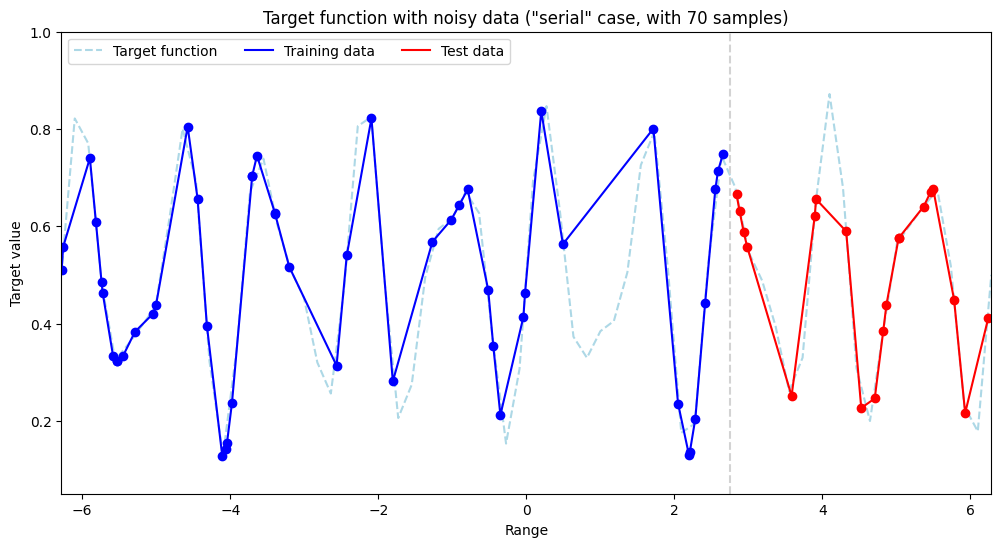

In [37]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples_train = 50
samples_valid = 20
samples = samples_train+samples_valid
train_pc = samples_train / samples
noise = 0.0

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Collect target function parameters
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
T   = (ub - lb)

### Prepare all X and y data
X_all   = np.linspace(lb, ub, num=samples)
y_all   = f.fun(X_all)
X_train = (ub_train - lb_train) * algorithm_globals.random.random(samples_train) + lb_train
X_train = np.sort(X_train, axis = 0)
y_train = f.fun(X_train) + noise * (algorithm_globals.random.random(samples_train) - 0.5)
X_valid = (ub_valid - lb_valid) * algorithm_globals.random.random(samples_valid) + lb_valid
X_valid = np.sort(X_valid, axis = 0)
y_valid = f.fun(X_valid) + noise * (algorithm_globals.random.random(samples_valid) - 0.5)

### Reshape Xs for fitting, scoring and prediction
X_all   = X_all.reshape(samples, 1)
X_train = X_train.reshape(samples_train, 1)
X_valid = X_valid.reshape(samples_valid, 1)

### Plot data
plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid,
    xlim=(lb, ub), ylim=(0.05, 1),
    colors=['lightblue', 'blue', 'red', 'blue', 'red'], linestyles=['dashed', 'solid', 'solid'],
    title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)',
    save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_noise.eps')

In [13]:
print(f'X train: {X_train[0:5]}')
print(f'y train: {y_train[0:5]}')

X train: [[-6.27850121]
 [-6.25734171]
 [-5.89671695]
 [-5.81518432]
 [-5.73868381]]
y train: [0.51053758 0.55787456 0.74006597 0.60878606 0.48458537]


## Create a serial model to fit data

### Identify device

In [14]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

('CPU', 'GPU')

In [15]:
### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device

'CPU'

In [16]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

sampler.options

Options()

### Create a serial model and test it

ParameterView([Parameter(W[000]), Parameter(W[001]), Parameter(W[002]), Parameter(W[003]), Parameter(W[004]), Parameter(W[005]), Parameter(W[006]), Parameter(W[007]), Parameter(W[008]), Parameter(W[009]), Parameter(W[010]), Parameter(W[011]), Parameter(W[012]), Parameter(W[013]), Parameter(W[014]), Parameter(W[015]), Parameter(W[016]), Parameter(W[017]), Parameter(X)])



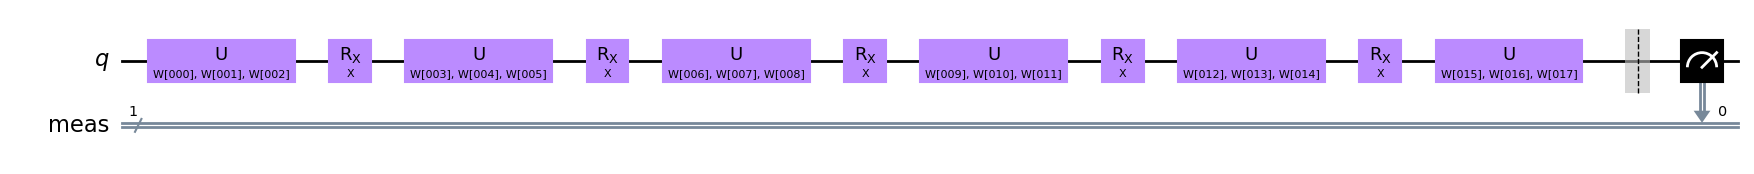

In [17]:
### Create a custom serial model circuit 
#   - To be used with CircuitQNN / NeuralNetworkRegressor

def serial_fourier_model(layers, add_meas=False):
    
    ansatz = QuantumCircuit(1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter
    params = []

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        nonlocal params
        param_w_0 = Parameter(f'{label}[{pno:03d}]')
        param_w_1 = Parameter(f'{label}[{pno+1:03d}]')
        param_w_2 = Parameter(f'{label}[{pno+2:03d}]')
        params += [param_w_0, param_w_1, param_w_2]
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')

    if add_meas:
        ansatz.measure_all()

    # Create a parameter list
    params += [param_x]

    return ansatz 

# Show a sample serial model with the specified number of layers
m = serial_fourier_model(5, add_meas=True)

# Show all parameters, the last is X
print(m.parameters)
print()

# Show the circuit
display(m.draw(output='mpl', style='clifford', scale=1, fold=True))
print()

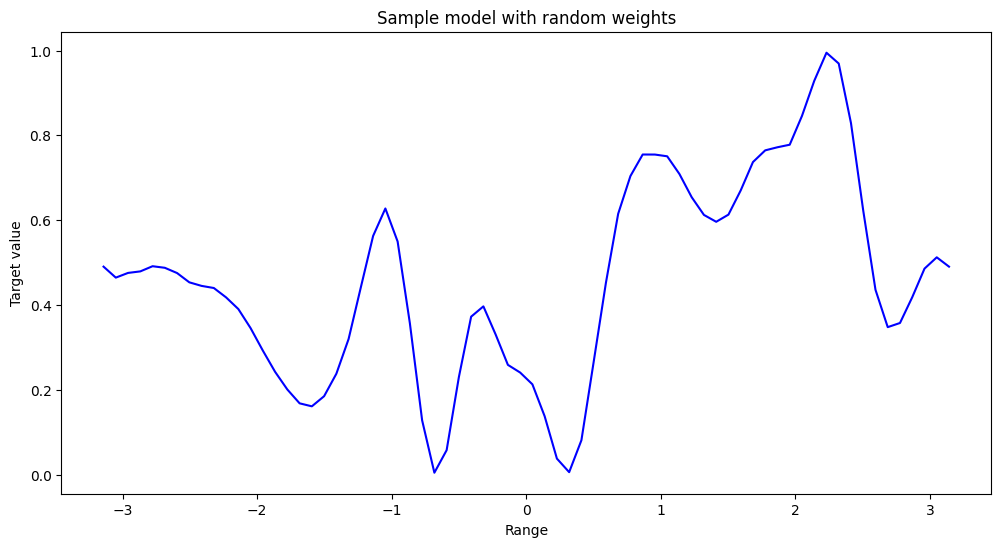

In [18]:
### Test a serial model
#   - Note that when layers=1 it will always generate a sine/cosine function
#   - Without a random seed it will produce a different function every time

if debug:

    # Start the random process
    algorithm_globals.random_seed = seed

    # Define the ansatz architecture and prepare X, y vectors
    layers = 27
    x_vect = np.linspace(-np.pi, np.pi, 70)
    y_vect = []
    
    # Initialise all parameters to random values (X is last)
    param_vals = algorithm_globals.random.random((layers+1)*3+1) * 2 * np.pi

    # Use ansatz to generate x, y pairs
    for x in x_vect:
        
        # Create a circuit for each new value of x
        model = serial_fourier_model(layers, add_meas=True)
        param_vals[-1] = x
        init_weights = param_vals[:-1]
        model_inst = model.assign_parameters(param_vals)

        # Generate y as expectation value of measuring '0'
        backend = Aer.get_backend('statevector_simulator') 
        result = sampler.run(model_inst, shots=shots).result()
        counts = result.quasi_dists[0]
        y_vect.append(counts[0])

    # Plot the curve
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title("Sample model with random weights")
    plt.xlabel("Range")
    plt.ylabel("Target value")
    plt.plot(x_vect, y_vect, color='blue')
    plt.show()

### Construct a model

In [19]:
# Define our output

output_shape = 2
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2
identity_interpret = lambda x: x

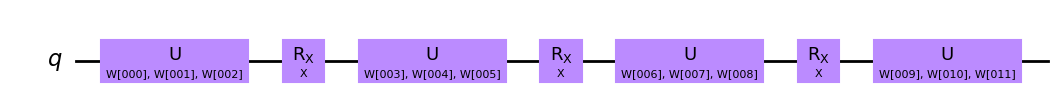

Model parameters: [Parameter(W[000]), Parameter(W[001]), Parameter(W[002]), Parameter(W[003]), Parameter(W[004]), Parameter(W[005]), Parameter(W[006]), Parameter(W[007]), Parameter(W[008]), Parameter(W[009]), Parameter(W[010]), Parameter(W[011])]


The number of test model parameters: 13

Forward pass result for SamplerQNN:
[[0.16008538 0.83991462]
 [0.15979309 0.84020691]
 [0.18265802 0.81734198]
 [0.19576772 0.80423228]
 [0.21086346 0.78913654]].  

Shape: (50, 2), Time: 0.0125 secs


In [20]:
### Test

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Define model, its parameters and their initial values (including random input)
layers = 3 # 3 # 9 # 15 # 21 # 27 # 33
model = serial_fourier_model(layers)
init_weights = 2 * np.pi * algorithm_globals.random.random((layers+1)*3)

sample_qnn = SamplerQNN(
    circuit=model,
    input_params=[model.parameters[-1]],
    weight_params=model.parameters[:-1],
    interpret=first_only,
    output_shape=output_shape,
    sampler=sampler
)

sample_data = X_train

start = time.time()
probs = sample_qnn.forward(sample_data, init_weights)
elapsed = time.time() - start

display(model.draw(output='mpl', style='clifford', scale=1, fold=True))
print(f'Model parameters: {model.parameters[:-1]}\n')
print(f'\nThe number of test model parameters: {model.num_parameters}\n')
print(f'Forward pass result for SamplerQNN:\n{probs[0:5]}.  \n\nShape: {probs.shape}, Time: {np.round(elapsed, 4)} secs')

In [21]:
print('Training initiated, optimum parameters will be calculated')

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Define model, its parameters and their initial values (including random input)
layers = 27 # 3 # 9 # 15 # 21 # 27 # 33
model = serial_fourier_model(layers)
init_weights = 2 * np.pi * algorithm_globals.random.random((layers+1)*3)

regr_qnn = SamplerQNN(
    circuit=model,
    input_params=[model.parameters[-1]],
    weight_params=model.parameters[:-1],
    interpret=first_only,
    output_shape=output_shape,
    sampler=sampler
)

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500)
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500)
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16)
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks

optimizer = L_BFGS_B(maxiter=20)
regr_callback = Regr_callback(log_interval=20)
regr_callback.reset(obfun=[])

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss="squared_error",
    optimizer=optimizer, 
    initial_point=init_weights, 
    callback=regr_callback.graph
)

print('Regressor with', optimizer.setting.splitlines()[0])
print('Optimiser settings', optimizer.settings)
print(f'Model parameters: {model.parameters[:-1]}\n')
print(f'\nThe number of training model parameters: {regressor.neural_network.circuit.num_parameters}\n')
# display(regr_qnn.circuit.draw(output='mpl', style='clifford', scale=1, fold=True))

Training initiated, optimum parameters will be calculated
Regressor with Optimizer: L_BFGS_B
Optimiser settings {'maxfun': 15000, 'maxiter': 20, 'ftol': 2.220446049250313e-15, 'iprint': -1, 'eps': 1e-08, 'max_evals_grouped': 1, 'options': {}}
Model parameters: [Parameter(W[000]), Parameter(W[001]), Parameter(W[002]), Parameter(W[003]), Parameter(W[004]), Parameter(W[005]), Parameter(W[006]), Parameter(W[007]), Parameter(W[008]), Parameter(W[009]), Parameter(W[010]), Parameter(W[011]), Parameter(W[012]), Parameter(W[013]), Parameter(W[014]), Parameter(W[015]), Parameter(W[016]), Parameter(W[017]), Parameter(W[018]), Parameter(W[019]), Parameter(W[020]), Parameter(W[021]), Parameter(W[022]), Parameter(W[023]), Parameter(W[024]), Parameter(W[025]), Parameter(W[026]), Parameter(W[027]), Parameter(W[028]), Parameter(W[029]), Parameter(W[030]), Parameter(W[031]), Parameter(W[032]), Parameter(W[033]), Parameter(W[034]), Parameter(W[035]), Parameter(W[036]), Parameter(W[037]), Parameter(W[038]

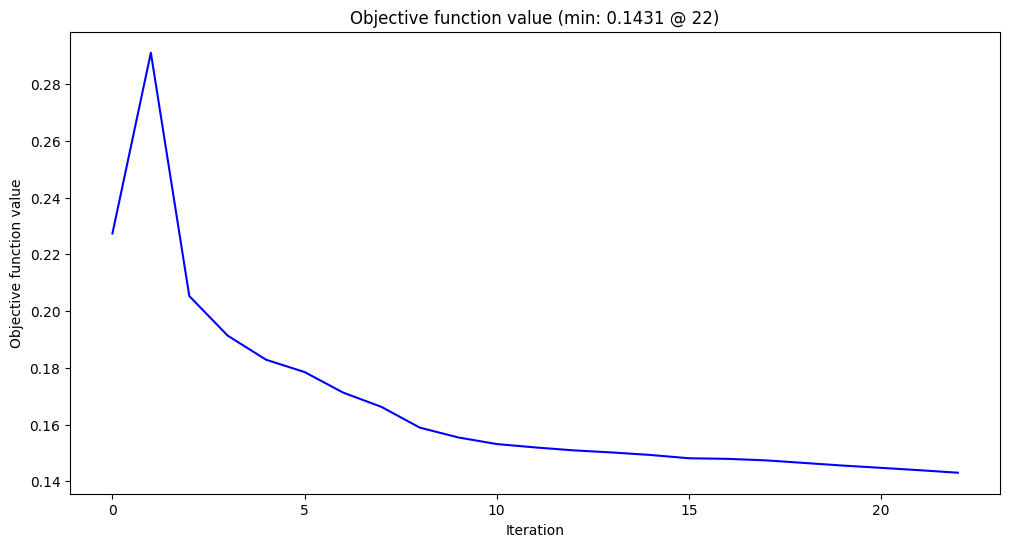

Optimum objective value: 0.1431 @ 22 (time=822.0 secs)


In [22]:
### Train the model

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Fit to data and plot progress
start = time.time()
regressor.fit(X_train, y_train) 
elapsed = time.time() - start

### Find the optimum objective fun value and NN weights
min_obj = regr_callback.min_obj()
print(f'Optimum objective value: {np.round(min_obj[1], 4)} @ {min_obj[0]} (time={np.round(elapsed, 0)} secs)')

## Score the model

In [23]:
### Calculate the score

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

yp_fun = np.array([yi for yi in f.fun(X_train)])
yp_train = np.array([[1-yi, yi] for yi in y_train])
yp_train_hat = np.array([y1 for y0, y1 in regressor.predict(X_train)])
yp_valid = np.array([[1-yi, yi] for yi in y_valid])
yp_valid_hat = np.array([y1 for y0, y1 in regressor.predict(X_valid)])

print('R2 for training data vs ground truth:\t', r2_score(yp_fun, y_train), '\n')

print('R2 for pred vs training data:\t\t', regressor.score(X_train, yp_train))
print('MAE for pred vs training data:\t\t', mean_absolute_error(y_train, yp_train_hat), '\n')

print('R2 for pred vs validation data:\t\t', regressor.score(X_valid, yp_valid))
print('MAE for pred vs validation data:\t', mean_absolute_error(y_valid, yp_valid_hat))

R2 for training data vs ground truth:	 1.0 

R2 for pred vs training data:		 -0.43226894108858005
MAE for pred vs training data:		 0.22140467528357327 

R2 for pred vs validation data:		 -2.1175088430183777
MAE for pred vs validation data:	 0.26089140304462316


## Find the fit and predictions

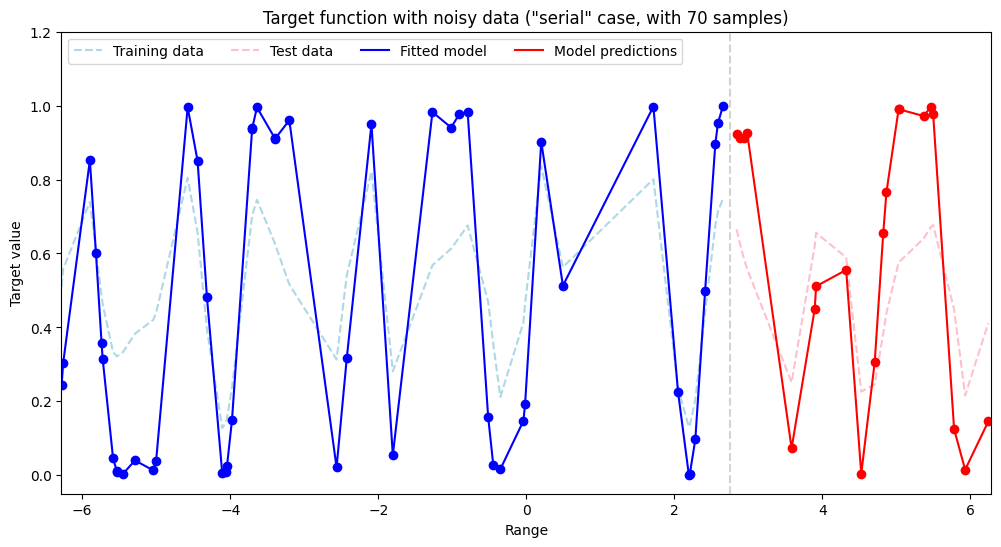

In [39]:
# plot_train_and_test_data(
#     X_all, y_all, X_train, y_train, X_valid, y_valid, yp_train_hat, yp_valid_hat,
#     xlim=(lb, ub), ylim=(0.05, 1.2),
#     colors=['lightblue', 'lightblue', 'pink', 'blue', 'red'], linestyles=['none', 'dashed', 'solid'],
#     title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)',
#     save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_pred.eps')

plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid, yp_train_hat, yp_valid_hat,
    xlim=(lb, ub), ylim=(-0.05, 1.2), legend_cols=4,
    colors=['orange', 'lightblue', 'pink', 'blue', 'red'], linestyles=['none', 'dashed', 'dashed', 'solid', 'solid'],
    title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)',
    save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_pred.eps')

## Save training data

In [40]:
### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   l: number of layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
opt_name = optimizer.setting.splitlines()[0][11:]
epochs = optimizer.settings["maxiter"]
TRAIN_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{1}_l{layers}_'+\
             f'{opt_name}_'+\
             f'ep{epochs}'
TRAIN_PREF

'serial_n70_z0.0_q1_l27_L_BFGS_B_ep20'

In [41]:
### Training info files 
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist{epochs}.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}_params.arr'
hist_chart_fpath = f'{FIGURES_PATH}/{TRAIN_PREF}_hist{epochs}.noise'
train_info_fpath

'log_1/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep20_info.json'

In [42]:
## Save training parameters
### Save info details
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_sample':samples,
     'data_split':train_pc,
     'data_noise':noise,
     'ansatz_qubits':model.num_qubits,
     'ansatz_layers':layers,
     'log_interv':1,
     'opt_name':opt_name,
     'epochs':epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "log_1/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep20_info.json":

	info[case_name] = serial
	info[major_version] = 8
	info[minor_version] = 9
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0.0
	info[ansatz_qubits] = 1
	info[ansatz_layers] = 27
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 20
	info[shots] = 10000
	info[seed] = 2022



In [43]:
### Save the history file
write_ts_file(init_fpath, init_weights)
write_ts_file(history_fpath, regr_callback.objfun_vals)
write_ts_file(params_fpath, regr_callback.params_vals)

## System details

In [44]:
!pip list | grep -e qiskit -e torch

qiskit                        1.0.2
qiskit-aer-gpu                0.14.1
qiskit-algorithms             0.3.0
qiskit-finance                0.4.1
qiskit-machine-learning       0.7.2
qiskit-nature                 0.7.2
qiskit-optimization           0.6.1
qiskit-qasm3-import           0.4.2
torch                         2.3.0
torchaudio                    2.3.0
torchsummary                  1.5.1
torchvision                   0.18.0
